[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

Build a multi-agent system around chat models that customizes the research process.


In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [5]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

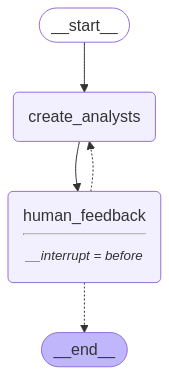

In [6]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
# display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
graph

In [7]:
# Input
max_analysts = 3 
topic = "Describe in detail how data fabric's architecture incorporates knowledge graphs and metadata activation, to facilitate seamless data integration and accessibility."
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Data Integration Institute
Role: Data Fabric Architect
Description: Dr. Carter focuses on the architectural design of data fabrics, emphasizing the integration of knowledge graphs. Her primary concern is how these graphs can be effectively utilized to create a more interconnected data environment, enhancing the ability to draw insights from disparate data sources. She is motivated by the potential of knowledge graphs to revolutionize data accessibility and integration.
--------------------------------------------------
Name: Raj Patel
Affiliation: Metadata Solutions Corp
Role: Metadata Activation Specialist
Description: Raj Patel specializes in the activation and utilization of metadata within data fabrics. His focus is on how metadata can be leveraged to improve data discoverability and integration processes. Raj is particularly interested in the automation of metadata management and its role in creating a seamless data integration experience. His m

In [8]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [9]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add someone who with a developer training background who can advise on the best websites and online training programs to go to learn more about the technologies in this topic"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff8013-33ec-6b50-8002-0f67093ef0c1'}}

In [10]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Data Integration Institute
Role: Data Fabric Architect
Description: Dr. Carter focuses on the architectural design of data fabrics, emphasizing the integration of knowledge graphs. Her primary concern is how these graphs can be effectively utilized to create a more interconnected data environment, enhancing the ability to draw insights from disparate data sources. She is motivated by the potential of knowledge graphs to revolutionize data accessibility and integration.
--------------------------------------------------
Name: Raj Patel
Affiliation: Metadata Solutions Corp
Role: Metadata Activation Specialist
Description: Raj Patel specializes in the activation and utilization of metadata within data fabrics. His focus is on how metadata can be leveraged to improve data discoverability and integration processes. Raj is particularly interested in the automation of metadata management and its role in creating a seamless data integration experience. His m

In [11]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff8013-d4af-674a-8004-4da2bae53132'}}

In [12]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [13]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [14]:
final_state.next

()

In [15]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Emily Zhang
Affiliation: Data Integration Solutions Inc.
Role: Data Architect
Description: Dr. Emily Zhang is a seasoned data architect with a focus on designing scalable data fabric architectures. Her primary concern is ensuring that knowledge graphs are effectively integrated into data fabric to enhance data connectivity and semantic understanding. She is motivated by the challenge of creating systems that allow for seamless data integration and accessibility across diverse data sources.
--------------------------------------------------
Name: Michael Thompson
Affiliation: TechEd Academy
Role: Developer Educator
Description: Michael Thompson is a developer educator with a background in software engineering and a passion for teaching. He advises on the best online resources and training programs for developers interested in data fabric technologies, knowledge graphs, and metadata activation. His goal is to empower developers with the skills needed to implement and innovate w

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [16]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [17]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [18]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [19]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [20]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

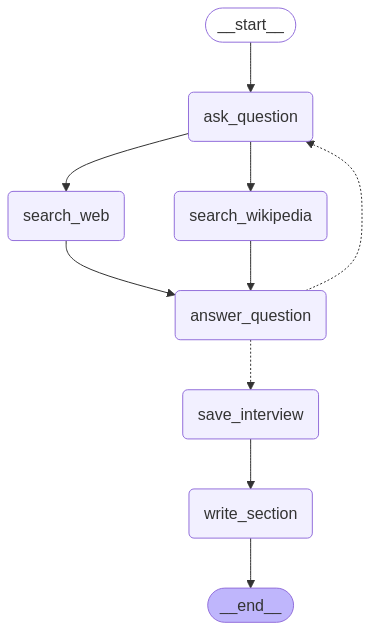

In [21]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [28]:
# Pick one analyst
analysts[2]

Analyst(affiliation='TechEd Academy', name='Lisa Thompson', role='Developer Educator', description='Lisa Thompson is a developer educator with a background in software development and data technologies. She advises on the best online resources and training programs for learning about data fabrics, knowledge graphs, and metadata. Her main concern is ensuring that developers have access to high-quality, up-to-date educational materials. Lisa is motivated by the desire to empower developers to effectively implement and utilize these technologies in their projects.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [29]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Designing Scalable and Flexible Data Fabrics with Knowledge Graphs

### Summary

In the rapidly evolving landscape of data management, the architectural design of data fabrics has emerged as a pivotal solution for organizations seeking to integrate and utilize data across diverse platforms. Data fabrics are designed to seamlessly integrate data from various formats and locations, making it easily accessible and usable by both humans and machines. This architecture is particularly significant for businesses aiming to enhance their analytics capabilities and drive digital transformation.

A novel aspect of data fabric architecture is its integration with knowledge graphs, which play a crucial role in enabling more agile and comprehensive data usage. Knowledge graphs provide a structured framework that enhances data connectivity and context, allowing organizations to extract valuable insights more efficiently. This integration is further powered by AI and metadata activation, which together facilitate consistent data governance and ensure the safety and accuracy of organizational data [1][2][3].

One of the most interesting insights from recent discussions is the role of knowledge graph engines in powering data fabric architectures. These engines enable businesses to unlock the full potential of their data by providing a dynamic and scalable framework for data integration. This capability is essential for organizations that need to adapt to the evolving needs of technology and business environments [3][4].

Moreover, the use of active metadata, semantics, and machine learning within data fabrics allows for streamlined data processes and improved data governance. This combination not only enhances data accessibility but also ensures that data remains accurate and secure across various platforms [1][5]. The ability to leverage these technologies within a data fabric architecture is a game-changer for businesses looking to modernize their data management practices and stay competitive in a data-driven world.

In summary, the integration of knowledge graphs within data fabric architectures represents a significant advancement in data management. By enabling more flexible and scalable data integration, these architectures provide organizations with the tools they need to harness the full potential of their data assets. As businesses continue to navigate the complexities of digital transformation, the adoption of data fabric architectures will be crucial in ensuring their success.

### Sources
[1] https://dev.to/buzzgk/data-fabric-architecture-unlocking-the-full-potential-of-data-439l  
[2] https://www.bigdatawire.com/2022/03/07/data-fabrics-the-killer-use-case-for-knowledge-graphs/  
[3] https://www.globallogic.com/insights/blogs/powering-the-data-fabric-architecture-with-a-knowledge-graph-engine/  
[4] https://www.itransition.com/blog/data-fabric-architecture  
[5] https://lumendata.com/ideas/understanding-modern-data-fabric-architecture-and-best-practices-to-modernize-enterprise-data/  

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [30]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

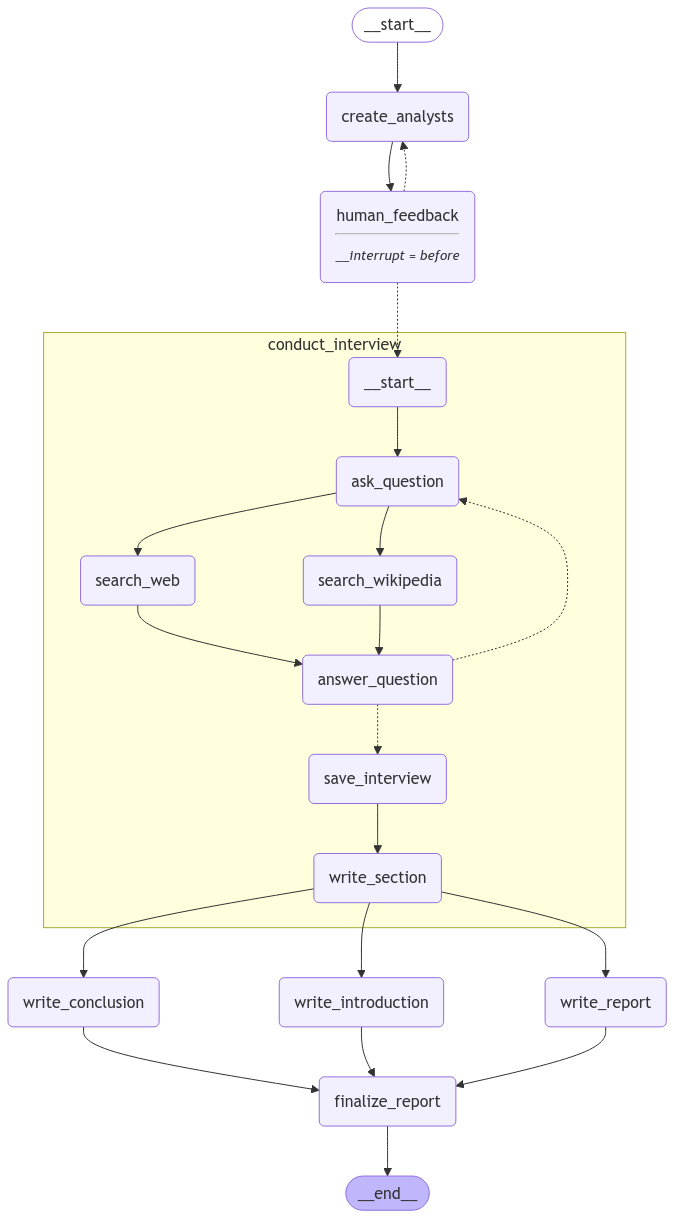

In [31]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [32]:
# Inputs
max_analysts = 3 
topic = "Outline the goals and benefits of using a data fabric; then go into detail about the most popular architectures and technologies used to develop a data fabric.  Cite specific industry examples."
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Research Institute
Role: Data Fabric Strategist
Description: Dr. Emily Carter focuses on the strategic implementation of data fabrics within organizations. Her primary concern is how data fabrics can streamline data management processes and enhance data accessibility across various platforms. She is motivated by the potential of data fabrics to break down data silos and improve decision-making efficiency. Dr. Carter often explores the goals and benefits of data fabrics, emphasizing their role in providing a unified data environment.
--------------------------------------------------
Name: Rajesh Kumar
Affiliation: Data Architecture Solutions
Role: Data Fabric Architect
Description: Rajesh Kumar is an expert in designing and implementing data fabric architectures. His focus is on the technical aspects, including the integration of various technologies such as data lakes, data warehouses, and cloud services. Rajesh is particularly interested in ho

In [33]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efeb135-ac6e-69be-8002-2967ed7d858f'}}

In [34]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Research Institute
Role: Data Fabric Strategist
Description: Dr. Emily Carter focuses on the strategic implementation of data fabrics within organizations. Her primary concern is how data fabrics can streamline data management processes and enhance data accessibility across various platforms. She is motivated by the potential of data fabrics to break down data silos and improve decision-making efficiency. Dr. Carter often explores the goals and benefits of data fabrics, emphasizing their role in providing a unified data environment.
--------------------------------------------------
Name: Rajesh Kumar
Affiliation: Data Architecture Solutions
Role: Data Fabric Architect
Description: Rajesh Kumar is an expert in designing and implementing data fabric architectures. His focus is on the technical aspects, including the integration of various technologies such as data lakes, data warehouses, and cloud services. Rajesh is particularly interested in ho

In [35]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efeb136-3c27-62fe-8004-3abb78f4c431'}}

In [36]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [37]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# The Transformative Power of Data Fabrics in Modern Enterprises

## Introduction

In today's data-driven world, enterprises face the challenge of managing vast amounts of data from diverse sources. Data fabrics have emerged as a transformative solution, offering a unified, integrated view of data that enhances accessibility, quality, and consistency. By leveraging AI, machine learning, and metadata activation, data fabrics streamline data integration, automate processes, and break down silos, leading to improved decision-making and operational efficiency. This report explores the goals and benefits of data fabrics, delves into popular architectures and technologies, and highlights industry examples that showcase their potential to revolutionize data management.

---



In the rapidly evolving landscape of data management, data fabrics have emerged as a transformative architecture that addresses the complexities of modern data environments. Enterprises today face challenges such as data silos, inconsistent data quality, and the need for seamless integration across diverse systems. Data fabrics offer a compelling solution by providing a unified, integrated view of data, enhancing accessibility, quality, and consistency across organizations. By leveraging technologies such as AI, machine learning, and metadata activation, data fabrics streamline data integration processes, facilitating improved decision-making and operational efficiency [1][2].

One of the key benefits of data fabrics is their ability to automate and augment data integration, significantly reducing the burden on IT departments and enabling more agile business processes. This is particularly beneficial for large enterprises where data is often scattered across various platforms and applications. The integration capabilities of data fabrics not only break down data silos but also enable centralized data management, which is crucial for maintaining data integrity and supporting business intelligence initiatives [1][2].

Data fabrics are designed to be flexible and reusable, allowing organizations to adapt quickly to changing business needs and technological advancements. This adaptability is essential in today's fast-paced business environment, where the ability to access and analyze data in real-time can provide a competitive edge. The use of data fabrics in business process management and process intelligence further underscores their role in driving transformational change within organizations [3].

Furthermore, data fabrics support enhanced data governance and security, which are critical concerns for enterprises handling sensitive information. By providing a holistic view of data, data fabrics facilitate better compliance with regulatory requirements and help mitigate risks associated with data breaches [4]. The integration of AI and machine learning within data fabrics not only enhances data quality and accessibility but also empowers organizations to make more informed decisions, ultimately leading to improved business outcomes.

In the context of AI, data fabrics are emerging as a pivotal strategy for enhancing AI model training and deployment. They provide a unified architecture that integrates data across various platforms, enhancing accessibility and accelerating data-driven insights. This approach is particularly beneficial in AI-driven environments where seamless data integration and real-time analytics are crucial for maintaining a competitive edge [1][2]. By supporting the convergence of technologies such as the Internet of Things (IoT) and AI, data fabrics enable the seamless integration of data from diverse sources, enhancing the overall value of AI initiatives [3].

In summary, data fabrics represent a significant advancement in data architecture, offering a robust framework for managing and leveraging data assets. As industries continue to adopt these technologies, data fabrics are poised to play a crucial role in the development of scalable and flexible data infrastructures, supporting enhanced data governance, improved data quality, and the rapid development and iteration of AI models.


---

## Conclusion

Data fabrics represent a transformative advancement in data architecture, offering enterprises a robust framework for managing and leveraging their data assets. By providing a unified, integrated view of data, data fabrics enhance accessibility, quality, and consistency across organizations, thereby facilitating improved decision-making and operational efficiency. The integration of AI and machine learning within data fabrics not only automates data integration but also supports enhanced data governance and security. As industries continue to adopt these technologies, data fabrics are poised to play a crucial role in the development of scalable and flexible data infrastructures, ultimately driving transformational change and innovation.

## Sources
[1] https://multishoring.com/blog/what-is-data-fabric-comprehensive-guide/  
[2] https://www.gartner.com/en/data-analytics/topics/data-fabric  
[3] https://appian.com/blog/acp/data-fabric/data-fabric-benefits  
[4] https://airbyte.com/data-engineering-resources/data-fabric  
[5] https://www.abiresearch.com/blog/data-fabric-use-cases-benefits-and-examples-for-enterprises  
[6] https://www.xenonstack.com/blog/data-fabric-benefits  
[7] https://www.splunk.com/en_us/blog/learn/data-fabric.html  
[8] https://en.wikipedia.org/wiki/Internet_of_

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r